In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [13]:
df = pd.read_csv("/content/cybersecurity_intrusion_data.csv")

In [14]:
print("Dataset Info:")
print(df.info())
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB
None


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [15]:
print(df.isnull().sum())

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


In [16]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns



In [17]:
# Fill numeric columns with median
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled missing values in '{col}' with median: {median_val}")

# Fill categorical columns with mode
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Filled missing values in '{col}' with mode: {mode_val}")


Filled missing values in 'encryption_used' with mode: AES


In [18]:
duplicates = df.duplicated().sum()

In [19]:
df = df.drop(columns=['session_id', 'unusual_time_access'])

In [20]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers capped")

    df[col] = df[col].clip(lower=lower, upper=upper)

network_packet_size: 37 outliers capped
login_attempts: 206 outliers capped
session_duration: 418 outliers capped
ip_reputation_score: 21 outliers capped
failed_logins: 323 outliers capped
attack_detected: 0 outliers capped


In [21]:
target_column = "attack_detected"

X = df.drop(columns=[target_column])
y = df[target_column]


In [22]:
categorical_cols = X.select_dtypes(include='object').columns
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le
    print(f"Encoded '{col}': {list(le.classes_)}")


Encoded 'protocol_type': ['ICMP', 'TCP', 'UDP']
Encoded 'encryption_used': ['AES', 'DES']
Encoded 'browser_type': ['Chrome', 'Edge', 'Firefox', 'Safari', 'Unknown']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
tree = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=10)
tree.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

In [25]:
# Accuracy on training data
train_accuracy = tree.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Accuracy on testing data
test_accuracy = tree.score(X_test, y_test)
print("Testing Accuracy:", test_accuracy)


Training Accuracy: 0.892253244199764
Testing Accuracy: 0.8920335429769392


In [26]:
y_pred = tree.predict(X_test)


print("\n Classification Report:")
print(classification_report(y_test, y_pred))



 Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1042
           1       1.00      0.76      0.87       866

    accuracy                           0.89      1908
   macro avg       0.92      0.88      0.89      1908
weighted avg       0.91      0.89      0.89      1908



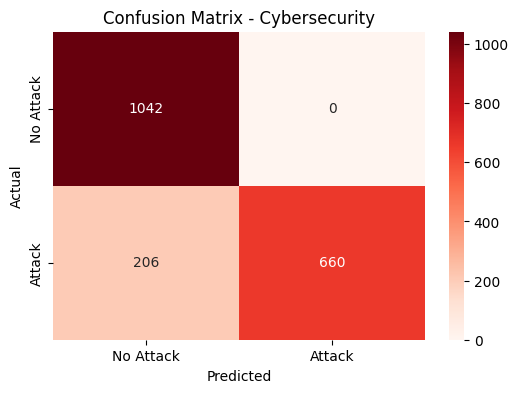

In [27]:


# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: use actual class names from your data
class_names = ['No Attack', 'Attack']

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Cybersecurity')
plt.show()


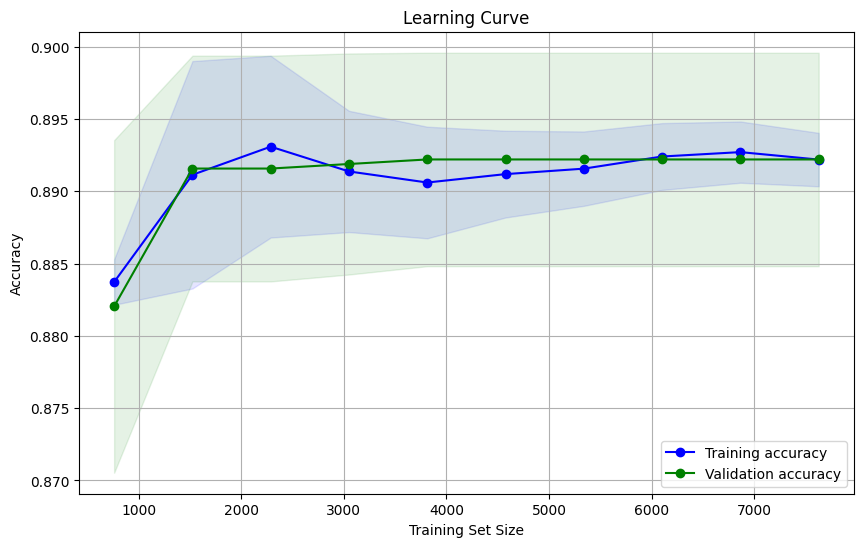

In [28]:


train_sizes, train_scores, test_scores = learning_curve(
    tree,
    X,
    y,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42,
    n_jobs=-1
)

# Calculate mean and std for train and test scores
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()


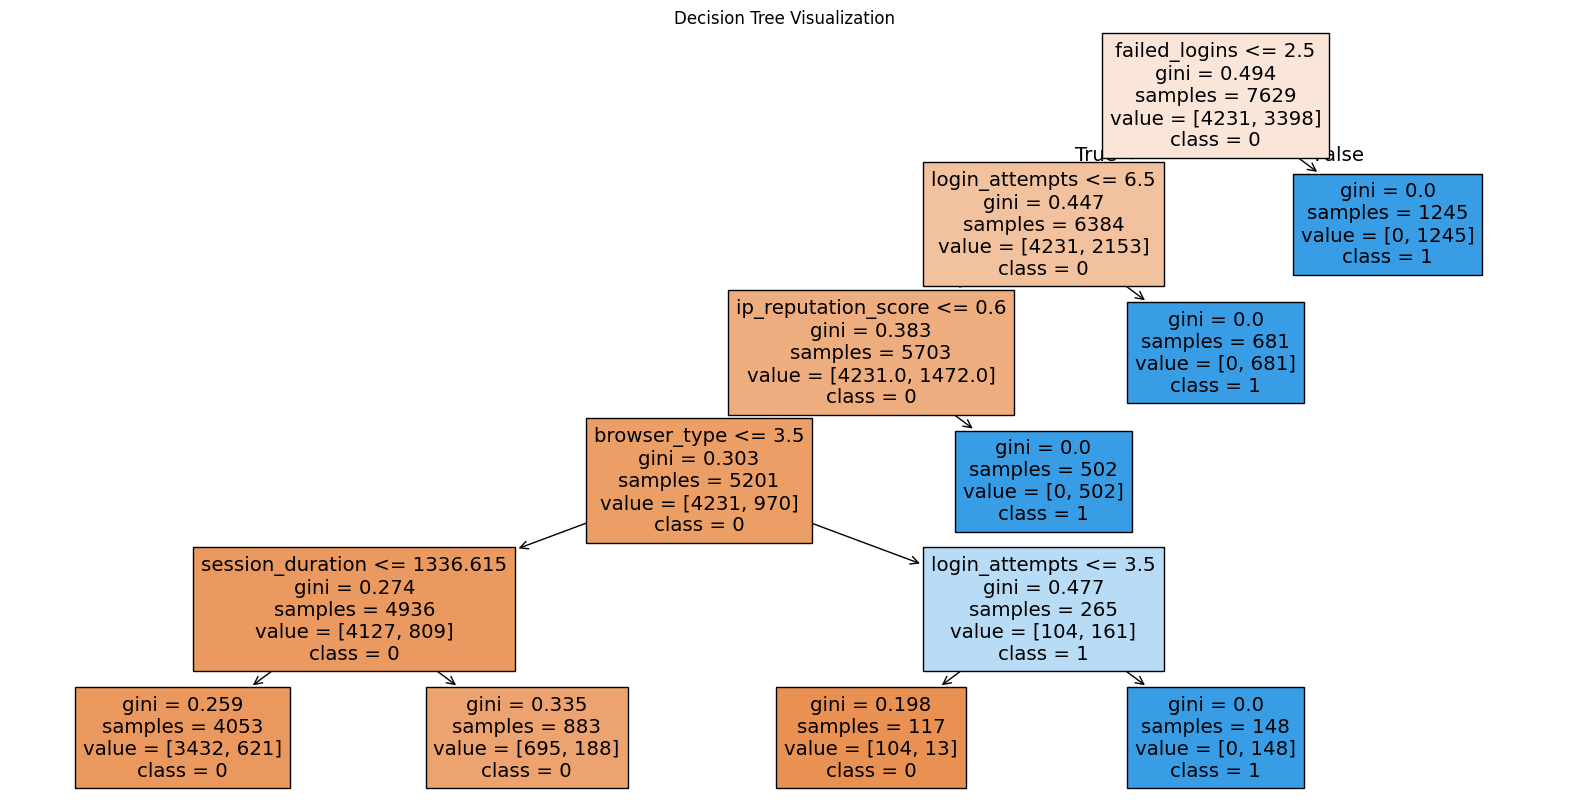

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, class_names=tree.classes_.astype(str), filled=True)
plt.title("Decision Tree Visualization")
plt.show()

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [43]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import uniform

# Set seed
np.random.seed(42)

# Pipeline with scaler + logistic regression
def train_and_evaluate(C_val):
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(solver='lbfgs', penalty='l2', C=C_val, max_iter=1000)
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

# Generate 30 random C values from uniform(0.001, 10)
C_samples = uniform(loc=0.001, scale=10).rvs(size=30)

best_score = 0
best_params = {}

for C_val in C_samples:
    acc = train_and_evaluate(C_val)
    if acc > best_score:
        best_score = acc
        best_params = {'C': C_val, 'penalty': 'l2'}

# Output
print("✅ Best Parameters:", best_params)
print("✅ Test Accuracy:", best_score)


✅ Best Parameters: {'C': np.float64(3.746401188473625), 'penalty': 'l2'}
✅ Test Accuracy: 0.7405660377358491


In [44]:
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42),
   'Logistic Regression': LogisticRegression(C=3.746, penalty='l2', max_iter=1000),
    'SVM': SVC(kernel='rbf', C=1.0)
}



In [45]:
for name, model in models.items():
    print(f"\n----- {name} -----")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Training Accuracy:", model.score(X_train, y_train))
    print("Testing Accuracy:", model.score(X_test, y_test))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


----- Decision Tree -----
Training Accuracy: 0.892253244199764
Testing Accuracy: 0.8920335429769392

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1042
           1       1.00      0.76      0.87       866

    accuracy                           0.89      1908
   macro avg       0.92      0.88      0.89      1908
weighted avg       0.91      0.89      0.89      1908


----- Logistic Regression -----
Training Accuracy: 0.730108795386027
Testing Accuracy: 0.7405660377358491

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.81      0.77      1042
           1       0.74      0.66      0.70       866

    accuracy                           0.74      1908
   macro avg       0.74      0.73      0.74      1908
weighted avg       0.74      0.74      0.74      1908


----- SVM -----
Training Accuracy: 0.883733123607288
Testing Accuracy: 0.87526205450733